In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import os
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Embedding, multiply, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


### Load and Preprocess the Dataset

In [6]:
# Load the data
(X_train, y_train), (_, _) = fashion_mnist.load_data()

# Normalize images to [0, 1] and reshape to (28, 28, 1)
X_train = X_train / 255.0
X_train = X_train.reshape(-1, 28 * 28)

# Number of classes
num_classes = 10


## Build Generator

In [7]:
def build_generator():
    noise_input = Input(shape=(100,))
    label_input = Input(shape=(1,), dtype='int32')

    # Embed the label and flatten it
    label_embedding = Embedding(num_classes, 100)(label_input)
    label_embedding = Flatten()(label_embedding)

    # Multiply noise and label embedding
    combined_input = multiply([noise_input, label_embedding])

    x = Dense(256)(combined_input)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = Dense(512)(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = Dense(784, activation='sigmoid')(x)  # 28x28 = 784

    img_output = Reshape((28, 28, 1))(x)

    return Model([noise_input, label_input], img_output)


## Build Discriminator

In [8]:
def build_discriminator():
    img_input = Input(shape=(28, 28, 1))
    label_input = Input(shape=(1,), dtype='int32')

    label_embedding = Embedding(num_classes, 28 * 28)(label_input)
    label_embedding = Flatten()(label_embedding)
    label_embedding = Reshape((28, 28, 1))(label_embedding)

    combined_input = multiply([img_input, label_embedding])

    x = Flatten()(combined_input)
    x = Dense(512)(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(0.2)(x)
    validity_output = Dense(1, activation='sigmoid')(x)

    return Model([img_input, label_input], validity_output)


## Build And Compile the CGAN

In [9]:
# Optimizer
optimizer = Adam(0.0002, 0.5)

# Build and compile discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build generator
generator = build_generator()

# Freeze discriminator in combined model
discriminator.trainable = False

# Combined CGAN model
noise = Input(shape=(100,))
label = Input(shape=(1,))
generated_img = generator([noise, label])
validity = discriminator([generated_img, label])

cgan = Model([noise, label], validity)
cgan.compile(loss='binary_crossentropy', optimizer=optimizer)


## Train the CGAN

In [10]:
def train(epochs, batch_size=128):
    half_batch = batch_size // 2

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        real_imgs = X_train[idx]
        real_labels = y_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_labels = np.random.randint(0, num_classes, half_batch)
        gen_imgs = generator.predict([noise, gen_labels])

        d_loss_real = discriminator.train_on_batch([real_imgs.reshape(-1, 28, 28, 1), real_labels], np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch([gen_imgs, gen_labels], np.zeros((half_batch, 1)))

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------
        noise = np.random.normal(0, 1, (batch_size, 100))
        sampled_labels = np.random.randint(0, num_classes, batch_size)

        valid_y = np.ones((batch_size, 1))

        g_loss = cgan.train_on_batch([noise, sampled_labels], valid_y)

        # Print the progress
        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}] [G loss: {g_loss:.4f}]")


## Generate and Visualize Images

1/1 [==============================] - 0s 226ms/step


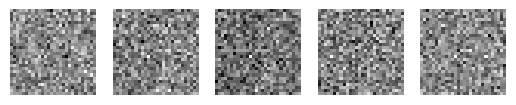

In [11]:
def generate_images(generator, label, num_images=5):
    noise = np.random.normal(0, 1, (num_images, 100))
    labels = np.full((num_images,), label)
    gen_imgs = generator.predict([noise, labels])

    gen_imgs = gen_imgs.reshape(-1, 28, 28)

    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(gen_imgs[i], cmap='gray')
        plt.axis('off')
    plt.show()

# Example: Generate 5 "Sneaker" images (class label = 7)
generate_images(generator, label=7)


## Train model

In [15]:
train(epochs=5000, batch_size=64)


1/1 [==============================] - 0s 31ms/step
0 [D loss: 0.6866, acc: 54.69] [G loss: 0.7304]
1/1 [==============================] - 0s 25ms/step
100 [D loss: 0.7041, acc: 51.56] [G loss: 0.7173]
1/1 [==============================] - 0s 29ms/step
200 [D loss: 0.6832, acc: 53.12] [G loss: 0.7126]
1/1 [==============================] - 0s 23ms/step
300 [D loss: 0.6903, acc: 57.81] [G loss: 0.7381]
1/1 [==============================] - 0s 32ms/step
400 [D loss: 0.7148, acc: 43.75] [G loss: 0.7338]
1/1 [==============================] - 0s 26ms/step
500 [D loss: 0.7108, acc: 42.19] [G loss: 0.7263]
1/1 [==============================] - 0s 24ms/step
600 [D loss: 0.6630, acc: 65.62] [G loss: 0.7686]
1/1 [==============================] - 0s 26ms/step
700 [D loss: 0.6774, acc: 51.56] [G loss: 0.7535]
1/1 [==============================] - 0s 30ms/step
800 [D loss: 0.6538, acc: 65.62] [G loss: 0.7428]
1/1 [==============================] - 0s 25ms/step
900 [D loss: 0.6998, acc: 46.88]

1/1 [==============================] - 0s 33ms/step


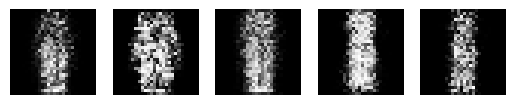

In [32]:
# Generate 5 "Dress" images
generate_images(generator, label=3)

1/1 [==============================] - 0s 14ms/step


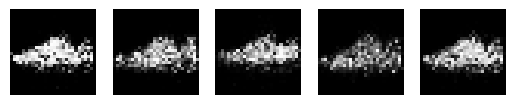

In [14]:
generate_images(generator, label=7)

1/1 [==============================] - 0s 44ms/step


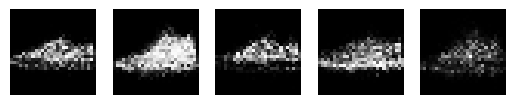

In [27]:
generate_images(generator, label=7)

1/1 [==============================] - 0s 35ms/step


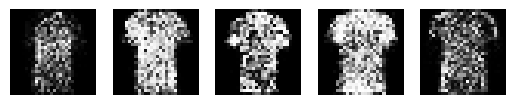

In [33]:
generate_images(generator, label=0)